# Reference $t^*$ table
For the new model, the reference $t^*$ table must be calibrated. Hereafter, I'll deconstruct the OGGM routine `t_star_from_refmb(...)` as point of reference...

In [426]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# import the needed OGGM modules
import oggm
from oggm import cfg
from oggm.utils import get_demo_file, get_rgi_glacier_entities
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, vascaling
from oggm.core.climate import mb_yearly_climate_on_glacier

# ---------------------
#  PREPROCESSING TASKS
# ---------------------

# create test directory
testdir = os.path.join(get_test_dir(), 'tmp_comparison')
if not os.path.exists(testdir):
    os.makedirs(testdir)
shutil.rmtree(testdir)
os.makedirs(testdir)

# load default parameter file
cfg.initialize()
cfg.set_intersects_db(get_demo_file('rgi_intersect_oetztal.shp'))
cfg.PATHS['working_dir'] = testdir
cfg.PATHS['dem_file'] = get_demo_file('hef_srtm.tif')
cfg.PATHS['climate_file'] = get_demo_file('histalp_merged_hef.nc')
cfg.PARAMS['border'] = 10
cfg.PARAMS['run_mb_calibration'] = True
cfg.PARAMS['baseline_climate'] = ''
cfg.PARAMS['use_multiprocessing'] = True
# use HistAlp climate data starting only from 1850
cfg.PARAMS['baseline_y0'] = 1850

# read the Hintereisferner DEM
hef_file = get_demo_file('Hintereisferner_RGI6.shp')
entity = gpd.read_file(hef_file).iloc[0]

# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=testdir)
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

# process the given climate file
climate.process_custom_climate_data(gdir)

# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

2019-02-13 11:28:28: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg
2019-02-13 11:28:36: oggm.core.gis: (RGI60-11.00897) define_glacier_region
2019-02-13 11:28:37: oggm.core.gis: (RGI60-11.00897) glacier_masks
2019-02-13 11:28:37: oggm.core.climate: (RGI60-11.00897) process_custom_climate_data
2019-02-13 11:28:37: oggm.core.centerlines: (RGI60-11.00897) compute_centerlines
2019-02-13 11:28:37: oggm.core.centerlines: (RGI60-11.00897) initialize_flowlines
2019-02-13 11:28:38: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_line
2019-02-13 11:28:38: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_bedshape
2019-02-13 11:28:38: oggm.core.centerlines: (RGI60-11.00897) catchment_area
2019-02-13 11:28:40: oggm.core.centerlines: (RGI60-11.00897) catchment_intersections
2019-02-13 11:28:40: oggm.core.centerlines: (RGI60-11.00897) catchment_width_geom
2019-02-13 11:28:42: oggm.core.centerlines: (RGI60-11.00897) catchment_width_correction


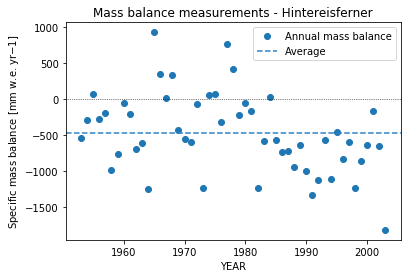

In [3]:
# get reference mass balance measurements
mbdf = gdir.get_ref_mb_data()['ANNUAL_BALANCE']
mbdf.name = 'Annual mass balance'
# get years with mb measurements
ref_years = mbdf.index.values
# compute average
ref_mb = np.mean(mbdf)
# visualize
ax = mbdf.plot(ls='None', marker='o')
ax.axhline(0, ls=':', c='k', lw=0.7)
ax.axhline(ref_mb, ls='--', c='#2c82c9', label='Average')
ax.set_title('Mass balance measurements - Hintereisferner')
ax.set_ylabel('Specific mass balance [mm w.e. yr$-1$]')
ax.legend()

In [4]:
# read climate info file
ci = gdir.read_pickle('climate_info')
# show values
for k, v in ci.items():
    if type(v) == str:
        print('{}: {:.40s}...'.format(k, v))
    else:
        print('{}: {}'.format(k, v))

baseline_climate_source: /Users/oberrauch/.oggm/oggm-sample-data-...
baseline_hydro_yr_0: 1851
baseline_hydro_yr_1: 2003


In [5]:
# Compute one mu candidate per year and the associated statistics
# Only get the years were we consider looking for tstar
y0, y1 = cfg.PARAMS['tstar_search_window']
ci = gdir.read_pickle('climate_info')
y0 = y0 or ci['baseline_hydro_yr_0']
y1 = y1 or ci['baseline_hydro_yr_1']
years = np.arange(y0, y1+1)

# define some index metrics and create empty container
ny = len(years)
mu_hp = int(cfg.PARAMS['mu_star_halfperiod'])
mb_per_mu = pd.Series(index=years)

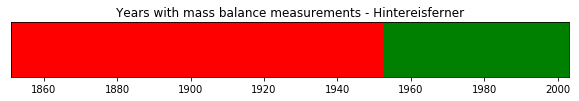

In [6]:
# visualize years with mass balance measurements
plt.figure(figsize=[10,1])
plt.yticks([])
plt.ylim([0,1])
plt.xlim([years[0], years[-1]])
plt.bar(years, np.isin(years, ref_years, invert=True), color='r', width=1)
plt.bar(years, np.isin(years, ref_years), color='g', width=1)
plt.title('Years with mass balance measurements - Hintereisferner');

In [28]:
# The old (but fast) method to find t*
_, temp, prcp = mb_yearly_climate_on_glacier(gdir, year_range=[y0, y1])

# which years to look at
selind = np.searchsorted(years, mbdf.index)
sel_temp = temp[selind]
sel_prcp = prcp[selind]
sel_temp = np.mean(sel_temp)
sel_prcp = np.mean(sel_prcp)

for i, y in enumerate(years):

    # Ignore begin and end
    if ((i - mu_hp) < 0) or ((i + mu_hp) >= ny):
        continue

    # Compute the mu candidate
    t_avg = np.mean(temp[i - mu_hp:i + mu_hp + 1])
    if t_avg < 1e-3:  # if too cold no melt possible
        continue
    mu = np.mean(prcp[i - mu_hp:i + mu_hp + 1]) / t_avg

    # Apply it
    mb_per_mu[y] = np.mean(sel_prcp - mu * sel_temp)

# add name to pd.Series
mb_per_mu.name = 'Modeled MB'

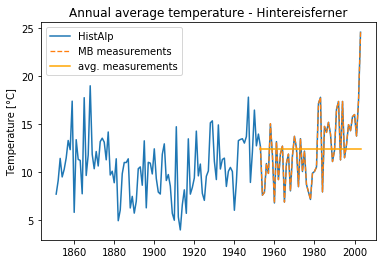

In [29]:
# plot temperature time series
plt.plot(years, temp, label='HistAlp')
# highlight years with mass balance measurements
plt.plot(ref_years, temp[selind], ls='--', lw=1.3,  label='MB measurements')
# plot average over period with mb measurements
plt.plot(ref_years, np.repeat(sel_temp, ref_years.size), c='orange', label='avg. measurements')
# add labels, title and legend
plt.ylabel('Temperature [°C]')
plt.title('Annual average temperature - Hintereisferner')
plt.legend();

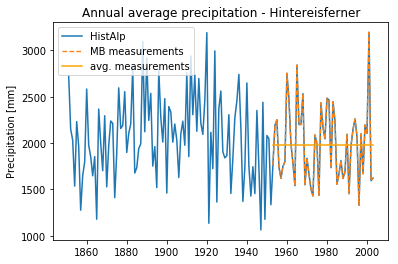

In [30]:
# plot precipitation time series
plt.plot(years, prcp, label='HistAlp')
# highlight years with mass balance measurements
plt.plot(ref_years, prcp[selind], ls='--', lw=1.3,  label='MB measurements')
# plot average over period with mb measurements
plt.plot(ref_years, np.repeat(sel_prcp, ref_years.size), c='orange', label='avg. measurements')
# add labels, title and legend
plt.ylabel('Precipitation [mm]')
plt.title('Annual average precipitation - Hintereisferner')
plt.legend();

The new but slow(er) method uses the `oggm.MultipleFlowlineMassBalance` model to compute the glacier average specific mass balance. Since my model has not even one flowline, I'm not looking into this method. The output of both is the same, namely the `mb_per_mu` series.

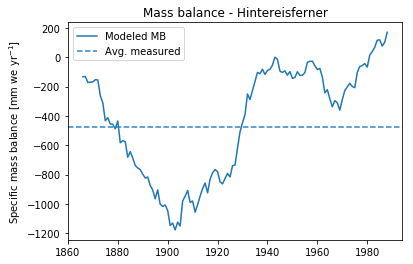

In [32]:
# visualize computed mass balance
ax = mb_per_mu.plot()
ax.axhline(ref_mb, c='#2c82c9', ls='--', label='Avg. measured')
ax.set_ylabel('Specific mass balance [mm we yr$^{-1}$]')
ax.set_title('Mass balance - Hintereisferner')
ax.legend()

Text(0,0.5,'Specific mass balance [mm w.e. yr$^{-1}$]')

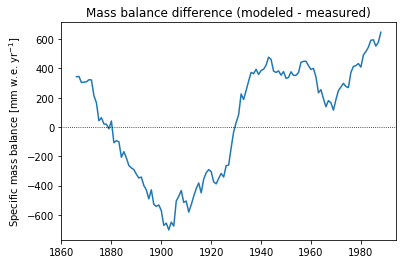

In [27]:
# compute modeled mass balance anomalies
# with repect to the average measured value
diff = (mb_per_mu - ref_mb).dropna()

In [47]:
# raise error if no mu* candidate is found, i.e. if the difference 
# between modeled mass balance and average measured mass balance
# never crosses the zero line @TODO: is that even true?!
if len(diff) == 0:
    raise MassBalanceCalibrationError('No single valid mu candidate for '
                                      'this glacier!')

In [74]:
# As of Jul 2018, we will now stop this non-sense:
# out of all mu*, let's just pick the one with the smallest bias.
# It doesn't make much sense, but the same is true for other methods
# as well -> this is how Ben used to do it, and he is clever
# Another way would be to pick the closest to today or something
amin = np.abs(diff).idxmin()
print('Year {} shows the smallest absolute mass balance bias of {:.1f} [mm w.e. yr-1]'.format(amin, diff[amin]))

Year 1879 shows the smallest absolute mass balance bias of -12.4 [mm w.e. yr-1]


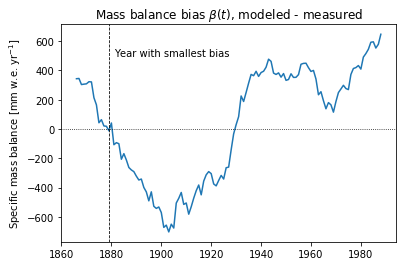

In [76]:
# visualize
ax = diff.plot()
ax.axhline(0, c='k', ls=':', lw=0.8)
ax.set_title(r'Mass balance bias $\beta(t)$, modeled - measured')
ax.set_ylabel('Specific mass balance [mm w.e. yr$^{-1}$]')
ax.axvline(amin, c='k', ls='--', lw=0.8)
ax.text(1881, 500, 'Year with smallest bias');

In [82]:
# Write
d = gdir.read_pickle('climate_info')
d['t_star'] = amin
d['bias'] = diff[amin]
# set flag to False (default)
write_diagnostics = False
if write_diagnostics:
    d['avg_mb_per_mu'] = mb_per_mu
    d['avg_ref_mb'] = ref_mb

gdir.write_pickle(d, 'climate_info')

# the result is returned by the function
result = {'t_star': amin, 'bias': diff[amin]}
result

{'t_star': 1879, 'bias': -12.407504191161365}

In [428]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-11.00897
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Name: Hintereisferner
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 8.036 km2
  Lon, Lat: (10.7584, 46.8003)
  Grid (nx, ny): (139, 94)
  Grid (dx, dy): (50.0, -50.0)

In [427]:
# NOTE: run first cell in order to perform all necessary prepo tasks

# Test my `t_star_from_refmb(...)` routine
import importlib
importlib.reload(vascaling)

# compute t* for Hintereisferner
vascaling.t_star_from_refmb(gdir)

{'t_star': 1884, 'bias': -6.816658475725376}

In [192]:
import pandas as pd
# read the `ref_tstar.csv` from my calibration
vas_ref = pd.read_csv('/Users/oberrauch/Desktop/ref_tstars.csv', index_col=0)
# read the `ref_tstar.csv` shipped with oggm
oggm_ref = cfg.PARAMS['ref_tstars_rgi6_histalp']

vas_ref.head()

,lon,lat,n_mb_years,tstar,bias
RGI60-11.00002,13.6135,47.4845,8,1911,25.030687
RGI60-11.00012,13.0581,47.4242,10,1967,1.894659
RGI60-11.00073,12.5956,47.1403,17,1983,6.710049
RGI60-11.00080,12.5964,47.1316,63,1932,2.570614
RGI60-11.00106,12.6967,47.0991,28,1890,-12.909590


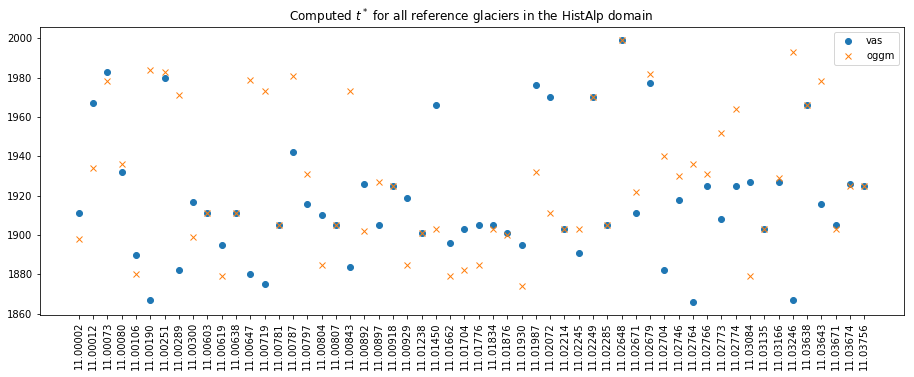

In [144]:
# create figure and axes
fig = plt.figure(figsize=[15,5])
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# plot t* from both reference lists
ax.plot(vas_ref['tstar'], ls='none', marker='o', label='vas')
ax.plot(oggm_ref['tstar'], ls='none', marker='x', label='oggm')
# set labels, etc.
ax.set_xticklabels([rgi_id[6:] for rgi_id in vas_ref.index], rotation = 90)
ax.set_title('Computed $t^*$ for all reference glaciers in the HistAlp domain')
ax.legend();

In [345]:
# combine DataFrames
pd.DataFrame([vas_ref['tstar'], oggm_ref['tstar']])

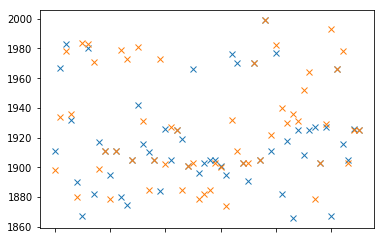

In [353]:
tmp = pd.DataFrame([vas_ref['tstar'], oggm_ref['tstar']])
tmp.plot(ls='None', marker='x', legend=False)

In [371]:
# combine DataFrames
tstar_df = pd.DataFrame([vas_ref['tstar'], oggm_ref['tstar']]).T
tstar_df.columns = [['vas', 'oggm']]
# get min/mas of combined data set and create temporal index 
tstar_years = np.arange(tstar_df.min().min(), tstar_df.max().max()+1)
# create empty DataFrame as matrix with RGI x years
tstar_mat = pd.DataFrame(index=tstar_df.index, columns=tstar_years)
tstar_mat.head()

,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
RGI60-11.00002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RGI60-11.00012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RGI60-11.00073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RGI60-11.00080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RGI60-11.00106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [393]:
print(rgi_id)
print(vas_tmp)

1866
1911


In [394]:
for rgi_id in tstar_mat.index:
    vas_tmp = tstar_df.loc[rgi_id, 'vas'].values[0]
    oggm_tmp = tstar_df.loc[rgi_id, 'oggm'].values[0]
    tstar_mat.loc[rgi_id, vas_tmp] = 1
    tstar_mat.loc[rgi_id, oggm_tmp] = 0

In [406]:
for ind, row in tstar_mat.iterrows():
    pass

In [423]:
rgi_id[7:]

'1.03756'

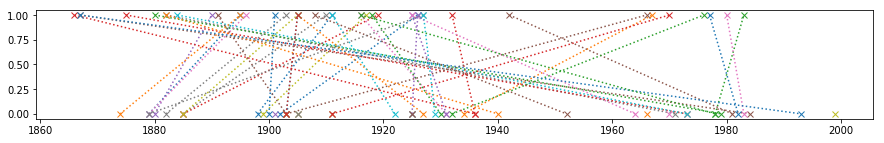

In [419]:

for rgi_id in tstar_mat.index:
    tstar_mat.loc[rgi_id].dropna().plot(ls=':', marker='${}$'.format(), figsize=[15,2])

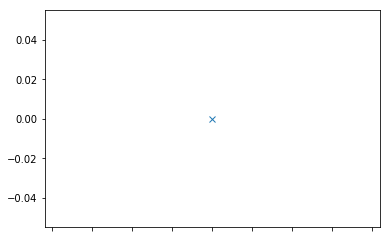

In [404]:
row.plot(marker='x')

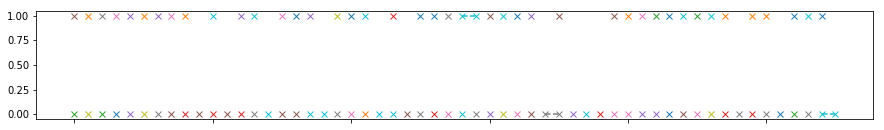

In [418]:
tstar_mat.plot(ls='--', marker='x', legend=False, figsize=[15,2])

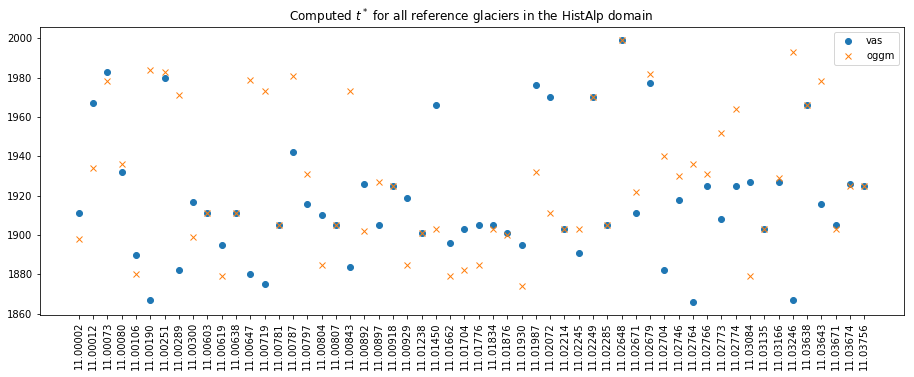

In [144]:
# create figure and axes
fig = plt.figure(figsize=[15,5])
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# plot t* from both reference lists
ax.plot(vas_ref['tstar'], ls='none', marker='o', label='vas')
ax.plot(oggm_ref['tstar'], ls='none', marker='x', label='oggm')
# set labels, etc.
ax.set_xticklabels([rgi_id[6:] for rgi_id in vas_ref.index], rotation = 90)
ax.set_title('Computed $t^*$ for all reference glaciers in the HistAlp domain')
ax.legend();

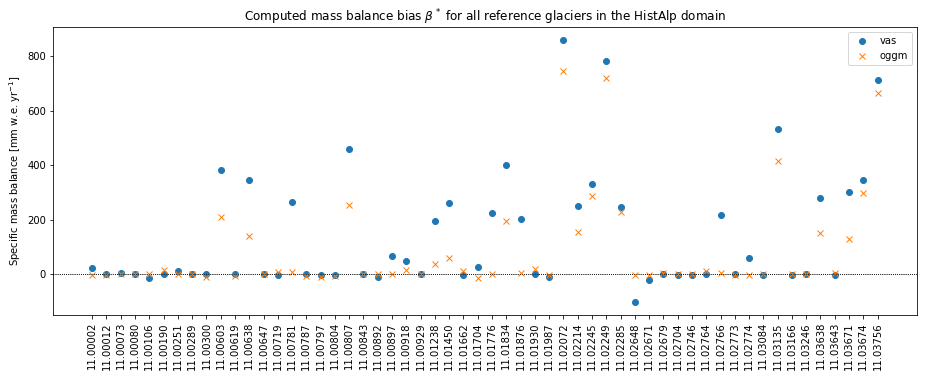

In [233]:
# create figure and axes
fig = plt.figure(figsize=[15,5])
ax = fig.add_axes([0.1,0.1,0.8,0.8])
ax.axhline(0, ls=':', lw=0.8, c='k')
# plot t* from both reference lists
ax.plot(vas_ref['bias'], ls='none', marker='o', label='vas')
ax.plot(oggm_ref['bias'], ls='none', marker='x', label='oggm')
ax.axhline(0, c='k', ls=':', lw=0.8)
# set labels, etc.
ax.set_ylabel(r'Specific mass balance [mm w.e. yr$^{-1}$]')
ax.set_xticklabels([rgi_id[6:] for rgi_id in vas_ref.index], rotation = 90)
ax.set_title(r'Computed mass balance bias $\beta^*$ for all reference glaciers in the HistAlp domain')
ax.legend();

In [299]:
# compute differences in t* between both reference lists
bias_dif = vas_ref[['bias']]-oggm_ref[['bias']]
bias_dif.columns = ['dif']
bias_dif['ind'] = np.arange(0, bias_dif.dif.size)
bias_dif['abs_dif'] = bias_dif.dif.abs()
bias_dif.head()

,dif,ind,abs_dif
RGI60-11.00002,28.861756,0,28.861756
RGI60-11.00012,3.323363,1,3.323363
RGI60-11.00073,5.178688,2,5.178688
RGI60-11.00080,1.656369,3,1.656369
RGI60-11.00106,-13.270704,4,13.270704


In [300]:
# compute some simple statistcs
stats = bias_dif[['dif', 'abs_dif']].describe()
stats

,dif,abs_dif
count,56.000000,56.000000
mean,52.547187,61.071186
std,83.778422,77.670666
min,-99.177894,0.735357
25%,-2.225067,4.893225
50%,8.176837,14.381992
75%,100.249644,103.031110
max,257.493652,257.493652


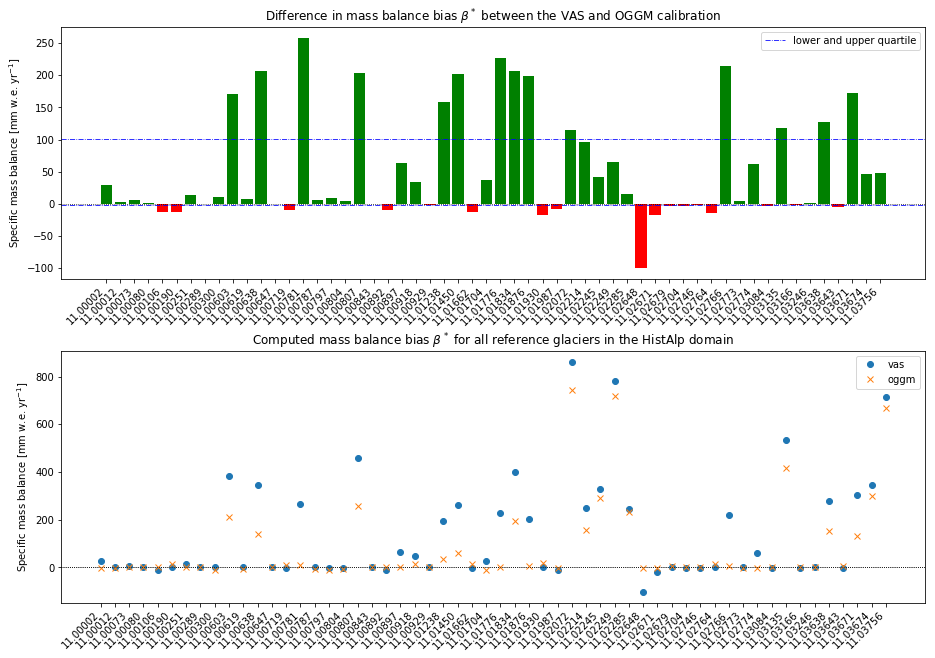

In [296]:
# create RGI ID indices
rgi_labels = [rgi_id[6:] for rgi_id in vas_ref.index]

# visualize differences
fig = plt.figure(figsize=[15,10])
ax = fig.add_axes([0.1,0.55,0.8,0.35])

# add auxilary lines (upper and lower quartile)
ax.axhline(stats.dif['25%'], c='b', ls='-.', lw=0.8)
ax.axhline(stats.dif['75%'], c='b', ls='-.', lw=0.8, label='lower and upper quartile')
ax.legend()

bias_dif_pos = bias_dif[bias_dif.dif >= 0].copy()
bias_dif_neg = bias_dif[bias_dif.dif < 0].copy()

ax.bar(bias_dif_pos.ind.values, bias_dif_pos.dif.values, color='g')
ax.bar(bias_dif_neg.ind.values, bias_dif_neg.dif.values, color='r')
ax.axhline(0, c='k', ls=':', lw=0.8)

ax.set_xticks(bias_dif.ind)
ax.set_xticklabels(rgi_labels, rotation=45, ha='right')
ax.set_ylabel(r'Specific mass balance [mm w.e. yr$^{-1}$]')
ax.set_title(r'Difference in mass balance bias $\beta^*$ between the VAS and OGGM calibration');

# visualize bias
ax = fig.add_axes([0.1,0.1,0.8,0.35])
ax.axhline(0, ls=':', lw=0.8, c='k')
# plot bias from both reference lists
ax.plot(vas_ref['bias'], ls='none', marker='o', label='vas')
ax.plot(oggm_ref['bias'], ls='none', marker='x', label='oggm')
ax.axhline(0, c='k', ls=':', lw=0.8)
# set labels, etc.
ax.set_ylabel(r'Specific mass balance [mm w.e. yr$^{-1}$]')
ax.set_xticklabels(rgi_labels, rotation=45, ha='right')
#ax.set_xticklabels([])
ax.set_title(r'Computed mass balance bias $\beta^*$ for all reference glaciers in the HistAlp domain')
ax.legend();

In [303]:
stats.abs_dif

count     56.000000
mean      61.071186
std       77.670666
min        0.735357
25%        4.893225
50%       14.381992
75%      103.031110
max      257.493652
Name: abs_dif, dtype: float64

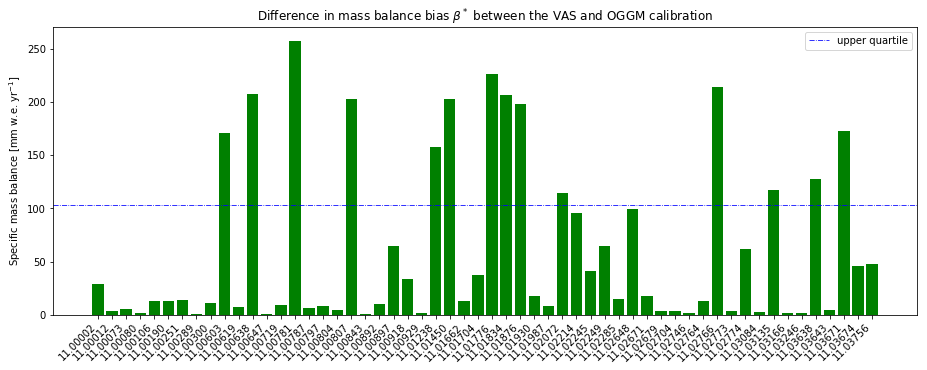

In [304]:
# create RGI ID indices
rgi_labels = [rgi_id[6:] for rgi_id in vas_ref.index]

# visualize differences
fig = plt.figure(figsize=[15,5])
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# add auxilary lines (upper and lower quartile)
ax.axhline(stats.abs_dif['75%'], c='b', ls='-.', lw=0.8, label='upper quartile')
ax.legend()

ax.bar(bias_dif.ind.values, bias_dif.abs_dif.values, color='g')
ax.axhline(0, c='k', ls=':', lw=0.8)

ax.set_xticks(bias_dif.ind)
ax.set_xticklabels(rgi_labels, rotation=45, ha='right')
ax.set_ylabel(r'Specific mass balance [mm w.e. yr$^{-1}$]')
ax.set_title(r'Difference in mass balance bias $\beta^*$ between the VAS and OGGM calibration');

In [308]:
# get glaciers with a mass balance bias difference outside the 75% quantile
large_bias = bias_dif.loc[bias_dif.abs_dif > stats.abs_dif['75%'], 'dif']
large_bias

RGI60-11.00603    170.426024
RGI60-11.00638    207.029684
RGI60-11.00781    257.493652
RGI60-11.00807    203.070013
RGI60-11.01238    157.828257
RGI60-11.01450    202.355616
RGI60-11.01776    226.594857
RGI60-11.01834    206.257711
RGI60-11.01876    198.482331
RGI60-11.02072    114.590758
RGI60-11.02766    214.040446
RGI60-11.03135    117.399886
RGI60-11.03638    127.847485
RGI60-11.03671    173.014383
Name: dif, dtype: float64

In [327]:
# get information (i.e. RGI entries) for 'problematic' glaciers
from oggm.utils import get_rgi_glacier_entities
large_bias_rgidf = get_rgi_glacier_entities(large_bias.index)
large_bias_rgidf[['RGIId', 'Name']]

,RGIId,Name
602,RGI60-11.00603,Vedretta Pendente
637,RGI60-11.00638,None
780,RGI60-11.00781,Jamtalferner
806,RGI60-11.00807,None
1237,RGI60-11.01238,Rhone
1449,RGI60-11.01450,None
1775,RGI60-11.01776,None
1833,RGI60-11.01834,Careser
1875,RGI60-11.01876,Gries
2071,RGI60-11.02072,None


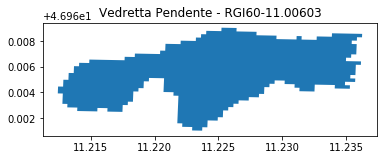

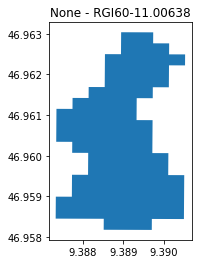

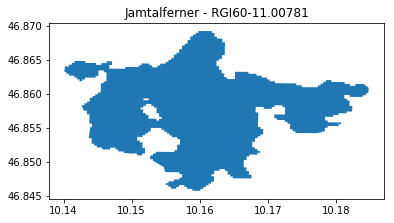

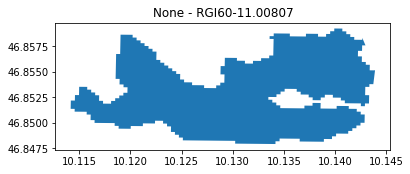

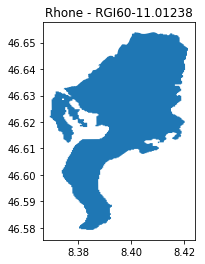

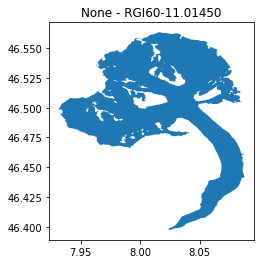

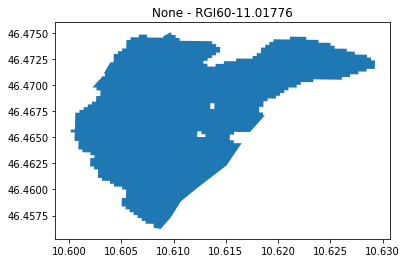

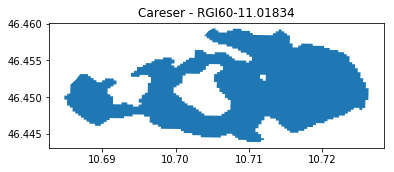

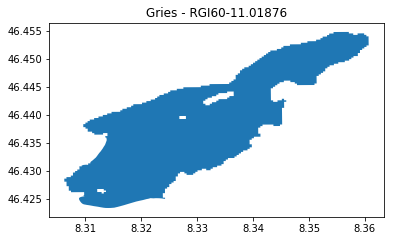

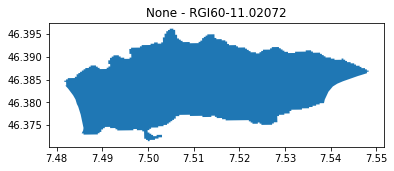

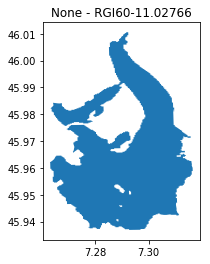

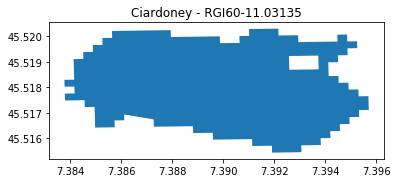

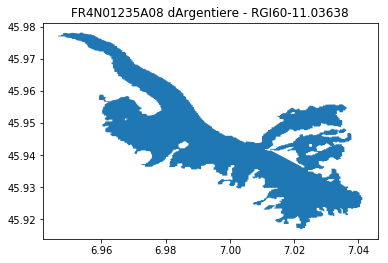

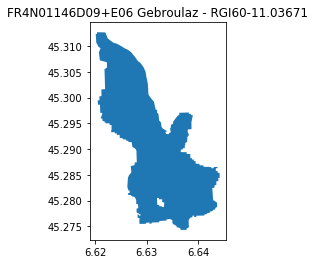

In [337]:
for rgi_id, row in large_bias_rgidf.iterrows():
    large_bias_rgidf.loc[[rgi_id], 'geometry'].plot()
    plt.title('{} - {}'.format(row['Name'], row['RGIId']))

In [292]:
# get basics statistics
stats = abs(bias_dif.dif).describe()
stats

count     56.000000
mean      61.071186
std       77.670666
min        0.735357
25%        4.893225
50%       14.381992
75%      103.031110
max      257.493652
Name: dif, dtype: float64

257.49365219989204

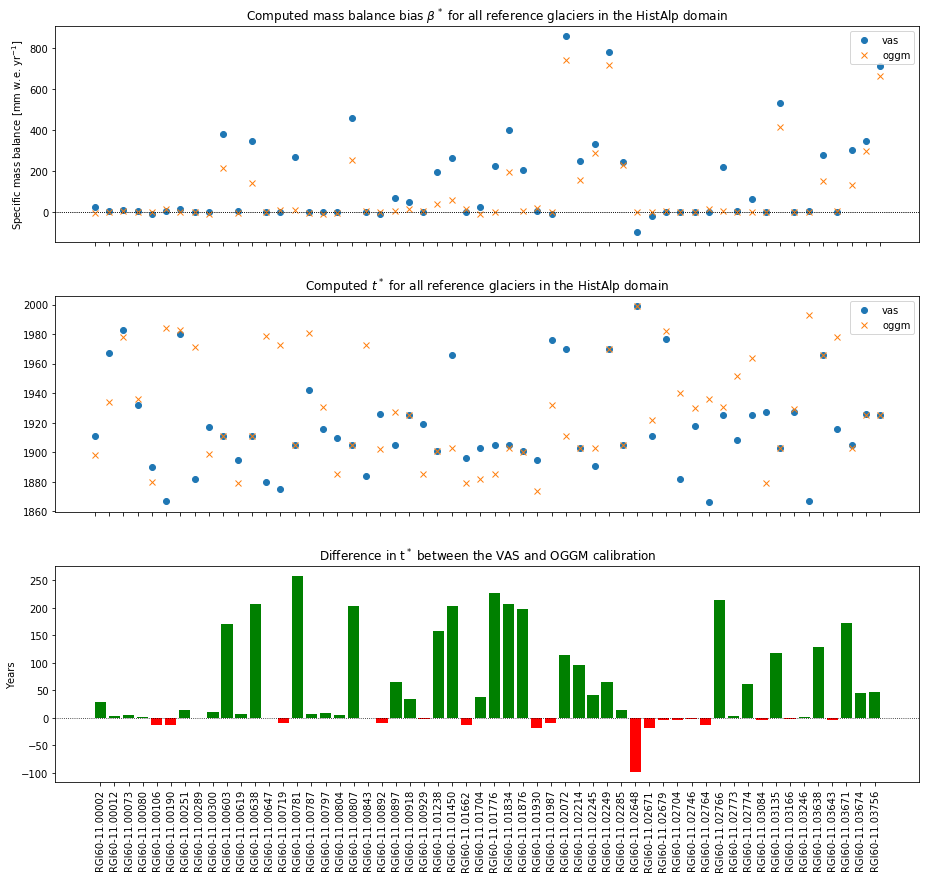

In [253]:
# compute differences in t* between both reference lists
bias_dif = vas_ref[['bias']]-oggm_ref[['bias']]
bias_dif.columns = ['dif']
bias_dif

# visualize
fig = plt.figure(figsize=[15,15])
ax = fig.add_axes([0.1,0.2,0.8,0.2])

bias_dif['ind'] = np.arange(0, bias_dif.dif.size)
bias_dif_pos = bias_dif[bias_dif.dif >= 0].copy()
bias_dif_neg = bias_dif[bias_dif.dif < 0].copy()

ax.bar(bias_dif_pos.ind.values, bias_dif_pos.dif.values, color='g')
ax.bar(bias_dif_neg.ind.values, bias_dif_neg.dif.values, color='r')
ax.axhline(0, c='k', ls=':', lw=0.8)

# ax.set_xlim(np.array([0, bias_dif.dif.size])-0.5)
ax.set_xticks(bias_dif.ind)
ax.set_xticklabels(bias_dif.index, rotation=90)

ax.set_ylabel('Years')
ax.set_title('Difference in t$^*$ between the VAS and OGGM calibration');

ax = fig.add_axes([0.1,0.45,0.8,0.2])
# plot t* from both reference lists
ax.plot(vas_ref['tstar'], ls='none', marker='o', label='vas')
ax.plot(oggm_ref['tstar'], ls='none', marker='x', label='oggm')
# set labels, etc.
#ax.set_xticklabels([rgi_id[6:] for rgi_id in vas_ref.index], rotation = 45)
ax.set_xticklabels([])
ax.set_title('Computed $t^*$ for all reference glaciers in the HistAlp domain')
ax.legend();

# create figure and axes
ax = fig.add_axes([0.1,0.7,0.8,0.2])
ax.axhline(0, ls=':', lw=0.8, c='k')
# plot t* from both reference lists
ax.plot(vas_ref['bias'], ls='none', marker='o', label='vas')
ax.plot(oggm_ref['bias'], ls='none', marker='x', label='oggm')
ax.axhline(0, c='k', ls=':', lw=0.8)
# set labels, etc.
ax.set_ylabel(r'Specific mass balance [mm w.e. yr$^{-1}$]')
# ax.set_xticklabels([rgi_id[6:] for rgi_id in vas_ref.index], rotation = 90)
ax.set_xticklabels([])
ax.set_title(r'Computed mass balance bias $\beta^*$ for all reference glaciers in the HistAlp domain')
ax.legend();